# Nissen et al., 2023: Severe 21st-century OA in Antarctic MPAs
#
# Fig. 2: Hovmoller plots of anthropogenic carbon in MPAs
#
# this script requires post-processed model output

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib import cm
from netCDF4 import Dataset, MFDataset
import pandas as pd
from numba import njit
from scipy.io import netcdf
from pylab import *
import math as mt
from matplotlib.patches import Rectangle
from tqdm import tqdm

In [2]:
#------
# General info
#------

# path to mask of MPAs
path_to_mask = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/masks/masks_MPAs/'

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig2_Hovmoller_OA_shelves_v2/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
# check if eps path exists
savepath2     = savepath+'eps/'
# check existence of paths
if not os.path.exists(savepath2):
    print ('Created '+savepath2)
    os.makedirs(savepath2)
    
#---
# load mesh info
#---

path_mesh = '/pscratch/sd/c/cnissen/'
file_mesh = 'Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'

f1 = Dataset(path_mesh+file_mesh) #xr.open_dataset(path+file1)
lat      = f1.variables['lat'][:]
lon      = f1.variables['lon'][:]
zlevs    = f1.variables['zlevs'][:]
cavities = f1.variables['cavity'][:]
topo     = f1.variables['topo'][:]
area     = f1.variables['cell_area'][:]
volume   = f1.variables['cell_volume'][:]
f1.close()
print(lat.shape)

ind_no_cavity = np.where(cavities==0)[0]
ind_cavities = np.where(cavities==1)[0]


(72411,)


In [3]:
#---
# FUNCTION to re-organize original FESOM output in cavities
#---

@njit
def reorganize_field_in_cavities(ind_cavities,data): 
    for ii in ind_cavities: #ind_cavities: 
        bb = data[:,ii] # get all depth levels at current cavity node
        ind_av = np.where(bb>0)[0] # get indices of all depth levels that are NOT masked
        #ind_av = bb>=0 #bb.mask==False
        #nd_av = np.where(ind_av==True)[0]
        #print ind_av
        # if surface value is filled, but thereafter there is a gap: 
        if len(ind_av)>1:
            if (ind_av[1]-ind_av[0])>1:  #any(np.diff(ind_av)>1):  
                bb[ind_av[1]-1]=bb[ind_av[0]] # move "surface" value to correct depth
                bb[ind_av[0]] = 0 # set surface entry to zero
               
        data[:,ii] = bb # overwrite original field
    return data


In [19]:
#---
# FUNCTION
#---

# get subareas based on lat only -> only need this to correctly define 'all_shelves' and 'all_openOcean'
def get_subarea_indices_sectors_lat_only(lat,lon):
    
    lat_threshold = -60 #-60 # 0=all SH data
        
    ross1 = 150 #160
    ross2 = -130 # -145
    
    eWeddell1 = -10
    
    print ('Subareas: south of '+str(-1*lat_threshold)+'°S...')
        
    shelf_ind = np.zeros(len(lon))
    for i in range(1,len(lon)+1):
        dd = lon[i-1]
        if lat[i-1]<lat_threshold and dd>-52 and dd<eWeddell1: # Filchner-Ronne & Larsen 
            shelf_ind[i-1]=1
        elif lat[i-1]<-74 and dd>-85 and dd<eWeddell1: # Filchner-Ronne & Larsen in the very south
            shelf_ind[i-1]=1
        elif lat[i-1]<lat_threshold and dd>eWeddell1 and dd<30: # eWeddell
            shelf_ind[i-1]=6
        elif lat[i-1]<lat_threshold and dd>30 and dd<90: # Prydz
            shelf_ind[i-1]=2
        elif lat[i-1]<lat_threshold and dd>90 and dd<ross1: # Amery & Australian
            shelf_ind[i-1]=3
        elif lat[i-1]<lat_threshold and dd>ross1:  # Ross Sea 
            shelf_ind[i-1]=4
        elif lat[i-1]<lat_threshold and dd<ross2:   # Ross Sea
            shelf_ind[i-1]=4
        elif lat[i-1]<lat_threshold and dd>ross2 and dd<-69: #dd<-66: # Amundsen & Bellinghausen
            shelf_ind[i-1]=5
        elif lat[i-1]<lat_threshold and dd>-69 and dd<-52: #dd<-66: # Antarctic Peninsula
            wap_lat = -70
            if lat[i-1]>wap_lat:
                shelf_ind[i-1]=7 # pensinsula
            else:
                #shelf_ind[i-1]=7 
                # now find correct separation between Amundsen & Weddell Sea
                if dd>-66:
                    shelf_ind[i-1]=1
                else:
                    shelf_ind[i-1]=5
                    
    return shelf_ind


# this array will be passed to 'get_indices_in_region()' function
shelf_ind = get_subarea_indices_sectors_lat_only(lat,lon)
ind = np.where((topo>2000) & (cavities==0))[0]
shelf_ind[ind]=0
shelf_ind[cavities==1]=0

def get_indices_in_region(rr,subregions,shelf_ind,path_to_mask):
    
    #----
    # get masks for MPAs
    #----

    f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_fesom_mesh_COARZE.nc')
    mask_WAP_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_fesom_mesh_COARZE.nc')
    mask_eastAA1_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_fesom_mesh_COARZE.nc')
    mask_eastAA2_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_fesom_mesh_COARZE.nc')
    mask_eastAA3_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_Orkney_fesom_mesh_COARZE.nc')
    mask_Orkney_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_RossSea_fesom_mesh_COARZE.nc')
    mask_RossSea_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_fesom_mesh_COARZE.nc')
    mask_WeddellSea_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    
    #print(shelf_ind.shape,lat.shape)

    if subregions[rr] in ['all_shelves']:
        ind_regions = np.where(shelf_ind>0)[0]
    elif subregions[rr] in ['all_openOcean']:
        ind_regions = np.where((shelf_ind==0) & (lat<=-60.0))[0]
    elif subregions[rr] in ['RossSea_MPA']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['RossSea_MPA_shelf']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (topo<=2020))[0] #(mesh.topo<=2000)
    elif subregions[rr] in ['RossSea_MPA_openOcean']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['WeddellSea_MPA']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['WeddellSea_MPA_shelf']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (topo<=2020))[0] #(mesh.topo<=2000)
    elif subregions[rr] in ['WeddellSea_MPA_openOcean']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA_shelf']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (topo<=2020))[0] #(mesh.topo<=2000)
    elif subregions[rr] in ['AntarcticPeninsula_openOcean']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['Orkney_MPA']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['Orkney_MPA_shelf']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['Orkney_MPA_openOcean']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (topo>2000))[0]
            
    elif subregions[rr] in ['East_Antarctica_1_MPA']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_1_MPA_shelf']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_1_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA_shelf']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA_shelf']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (topo>2000))[0]
            
    elif subregions[rr] in ['East_Antarctica_all_MPA']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_all_MPA_shelf']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (topo<=2020))[0] #(mesh.topo<=2000)
    elif subregions[rr] in ['East_Antarctica_all_MPA_openOcean']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (topo>2000))[0]
    
    #print(subregions[rr],ind_regions.shape)
    
    return ind_regions


Subareas: south of 60°S...


In [5]:
#-----
# load data: anthropogenic carbon
#-----

# define 'all_shelves' and 'all_openOcean' in this script

vari = 'bgc02_anth' 

which_sim = 'simAssp585'

#ind_av = np.where(shelf_ind>0)[0]
#print ('Process '+str(ind_av.shape[0])+' nodes for circumpolar shelves (outside of cavity)')

# load one example data array to mask correct nodes! (use rho, which is already corerctly reorganized in cavities)
path = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/PAPER2_postprocessed/rho0_fields/'
f1    = Dataset(path+'rho0_fesom_19900101.nc') # DIC
rho = f1.variables['rho0'][:,:,:].mean(axis=0)  # month x depth x mesh.n2d
f1.close()
del path

years = np.arange(1990,2100+1,1)

data_OA   = np.zeros([len(np.unique(zlevs)),len(lat),len(years)]) 
for yy in tqdm(range(0,len(years))):
    
    path = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/COARZE_AWICM_wREcoM_anthropogenic_carbon/'
    f1 = Dataset(path+vari+'_fesom_'+str(years[yy])+'0101.nc')
    data1 = f1.variables[vari][:,:] #.mean(axis=0)
    f1.close()
    
    # load rho0
    path = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/PAPER2_postprocessed/rho0_fields/'
    f1 = Dataset(path+'rho0_fesom_'+str(years[yy])+'0101.nc')
    data2 = f1.variables['rho0'][:,:,:].mean(axis=0)
    f1.close()
    
    #----
    # correct data in cavity
    #----
    # set masked values to 0 to get correction within cavity correct
    # (if I don't do that, masked and not-masked values are not correctly recognized with njit)
    data1[data1.mask==True]=0 
    data2[data2.mask==True]=0 
    # move "surface" value in cavities to correct depth
    data1 = reorganize_field_in_cavities(ind_cavities,data1)   
    data2 = reorganize_field_in_cavities(ind_cavities,data2)   
    
    #---
    # mask nodes that are not available
    #---
    data1 = np.ma.masked_where(rho.mask==True,data1)
    data2 = np.ma.masked_where(rho.mask==True,data2)
    
    # store anthropogenic carbon in mumol kg-1
    aux = 1000*np.divide(data1,data2) #data1
    aux = np.ma.masked_where(aux==1000,aux)
    data_OA[:,:,yy] = aux
    
    del data1,data2,aux
    
data_OA = np.ma.masked_where(data_OA==1000,data_OA)
print ('done')



  0%|          | 0/111 [00:00<?, ?it/s]/tmp/ipykernel_71538/1173236547.py:55: RuntimeWarning: divide by zero encountered in true_divide
  aux = 1000*np.divide(data1,data2) #data1
/tmp/ipykernel_71538/1173236547.py:55: RuntimeWarning: invalid value encountered in true_divide
  aux = 1000*np.divide(data1,data2) #data1
100%|██████████| 111/111 [03:15<00:00,  1.76s/it]


done


In [20]:
#----
# get avg depth profile in chosen subarea in each year
#----

regions = ['all_shelves','all_openOcean',\
           'RossSea_MPA_shelf','WeddellSea_MPA_shelf','East_Antarctica_all_MPA_shelf',\
           'AntarcticPeninsula_MPA_shelf','AntarcticPeninsula_MPA',\
           'Orkney_MPA','RossSea_MPA_openOcean','WeddellSea_MPA_openOcean',\
          'East_Antarctica_all_MPA_openOcean']

#-----
# get area contributions of subareas
#-----

area2 = np.copy(area)
area2 = np.tile(area2,[data_OA.shape[0],1])
num_depths = area2.shape[0]
area2 = np.ma.masked_where(rho.mask==True,area2) 
    
data_OA_regions = np.zeros([data_OA.shape[0],len(years),len(regions)])
for yy in range(0,len(years)):
    if np.mod(yy,10)==0:
        print ('Process ',years[yy])
        
    data = data_OA[:,:,yy]
    data = np.ma.masked_where(rho.mask==True,data) 
    
    for rr in range(0,len(regions)):
        #print regions[rr]
    
        ind1_so = get_indices_in_region(rr,regions,shelf_ind,path_to_mask)
        
        # loop over depths
        for dd in range(0,data_OA.shape[0]): 
            data_OA_regions[dd,yy,rr] = np.nansum(data[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])

    del data
    
print ('done')


Process  1990


/tmp/ipykernel_71538/1711044636.py:35: UserWarning: Warning: converting a masked element to nan.
  data_OA_regions[dd,yy,rr] = np.nansum(data[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])


Process  2000
Process  2010
Process  2020
Process  2030
Process  2040
Process  2050
Process  2060
Process  2070
Process  2080
Process  2090
Process  2100
done


(111, 99) (111, 99) (99, 111)
all_shelves


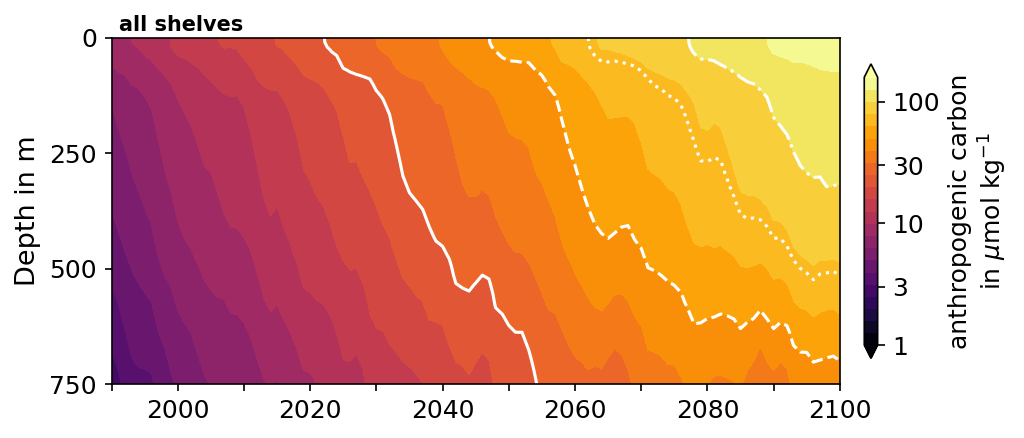

all_openOcean


/tmp/ipykernel_71538/3059990022.py:29: RuntimeWarning: invalid value encountered in log10
  plt.contourf(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\
/tmp/ipykernel_71538/3059990022.py:48: RuntimeWarning: invalid value encountered in log10
  plt.contour(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\


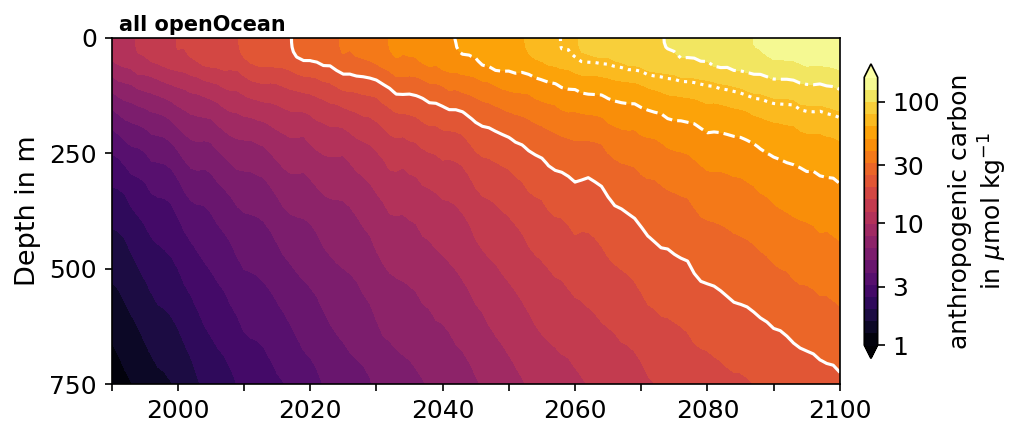

/tmp/ipykernel_71538/3059990022.py:63: RuntimeWarning: invalid value encountered in log10
  plt.contourf(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\
/tmp/ipykernel_71538/3059990022.py:78: RuntimeWarning: invalid value encountered in log10
  plt.contour(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\
/tmp/ipykernel_71538/3059990022.py:94: RuntimeWarning: invalid value encountered in log10
  plt.contourf(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\


RossSea_MPA_shelf


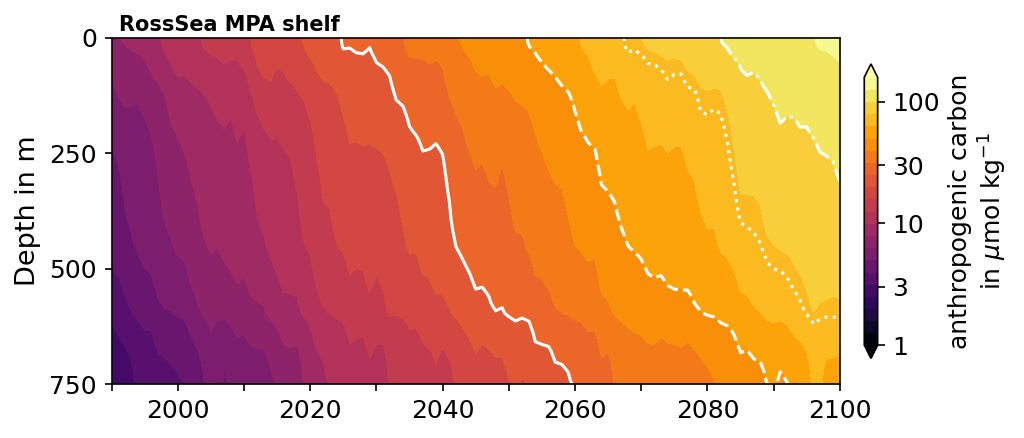

WeddellSea_MPA_shelf


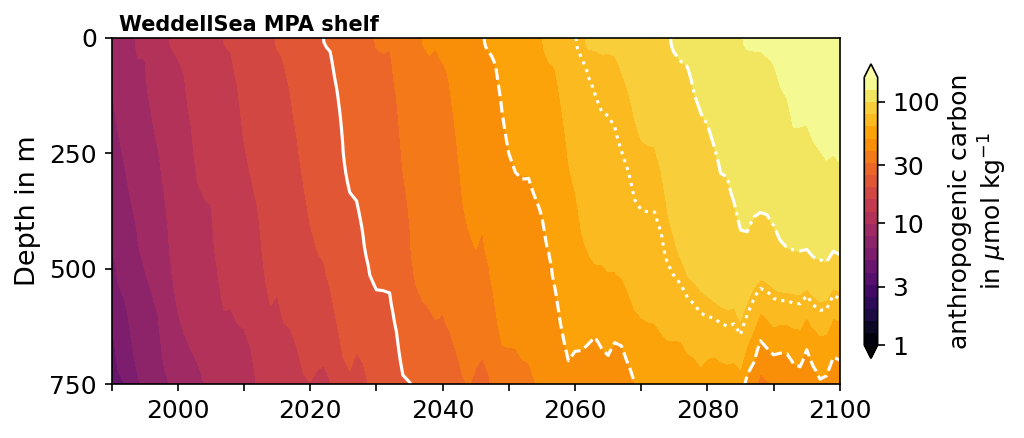

East_Antarctica_all_MPA_shelf


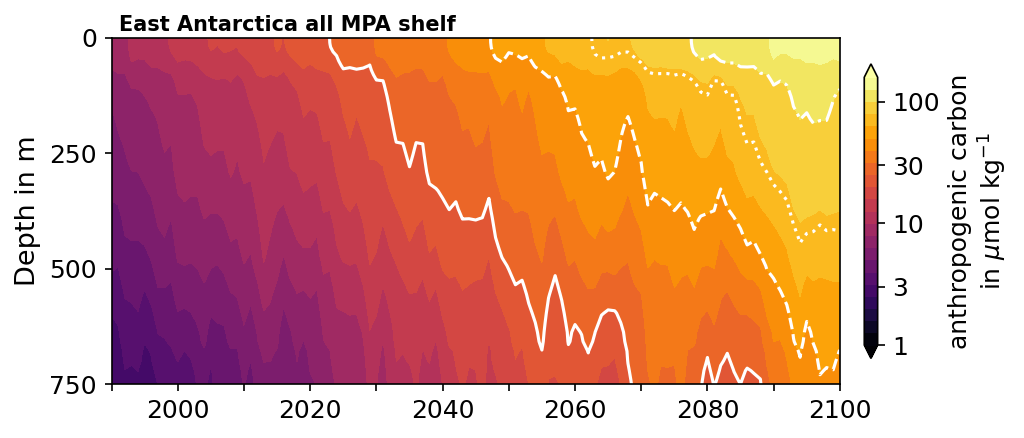

AntarcticPeninsula_MPA_shelf


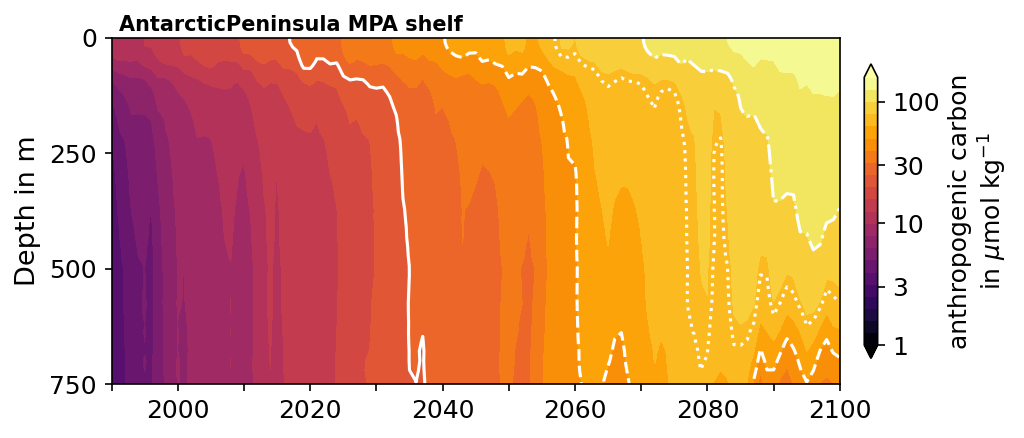

AntarcticPeninsula_MPA


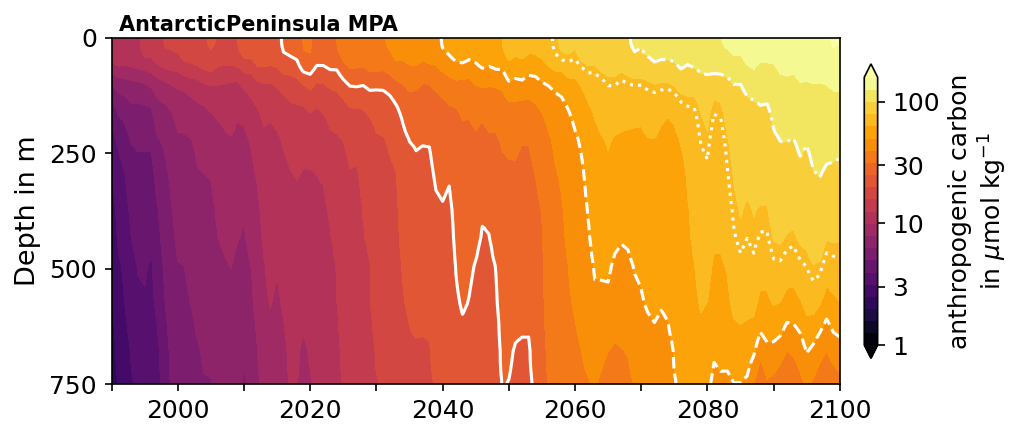

Orkney_MPA


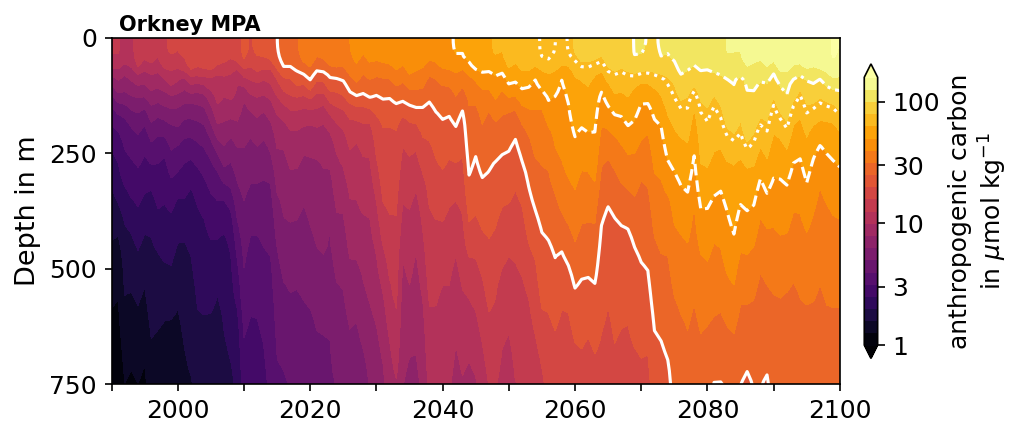

RossSea_MPA_openOcean


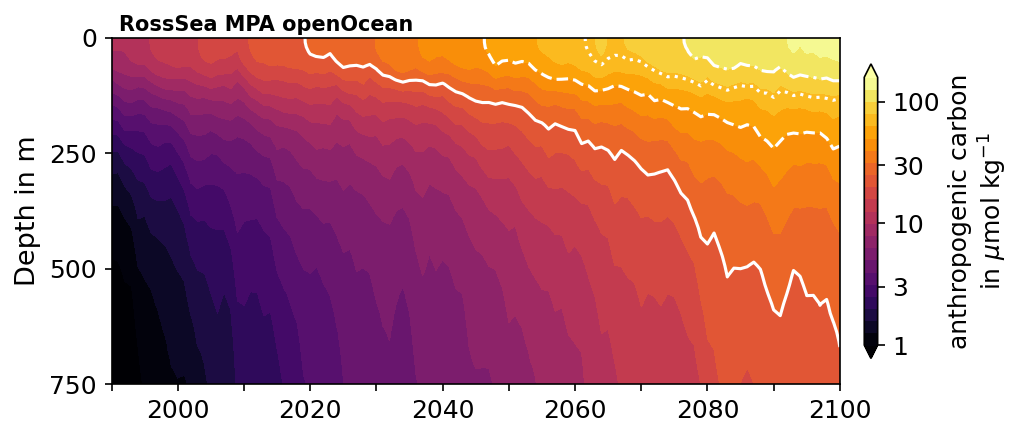

WeddellSea_MPA_openOcean


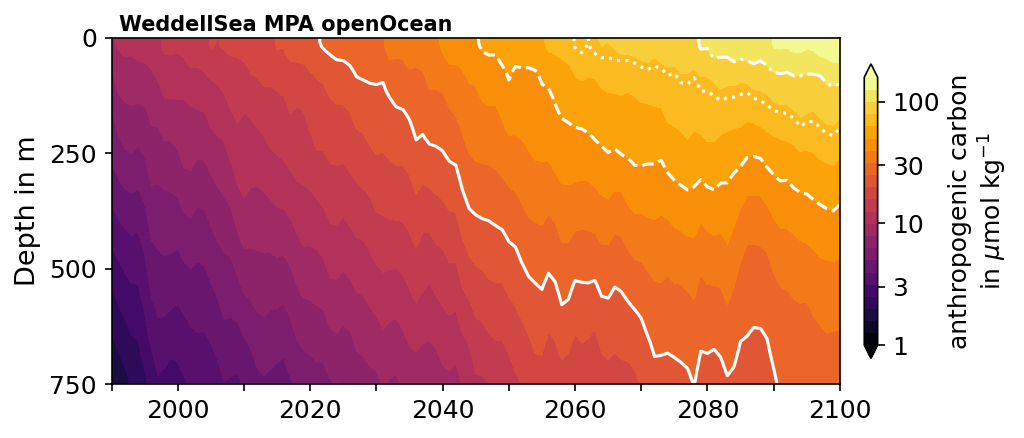

East_Antarctica_all_MPA_openOcean


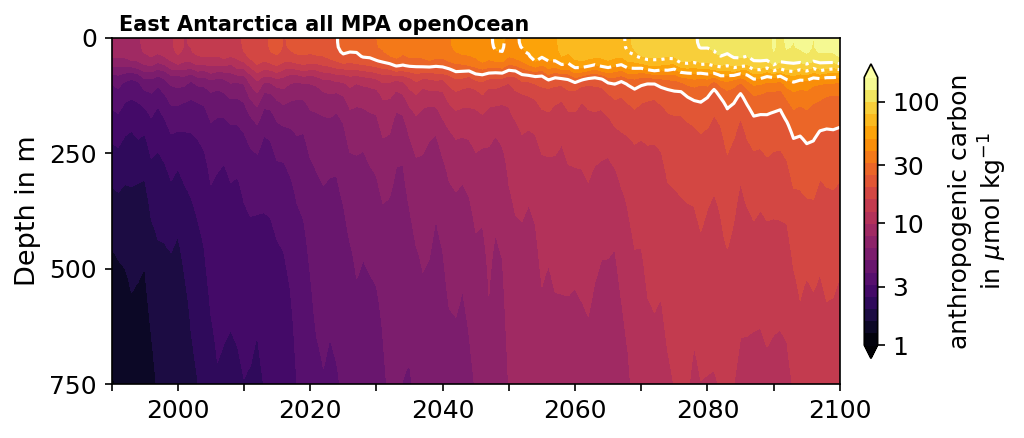

In [21]:
#----
# plot
#----

all_depths = np.tile(np.unique(zlevs),[len(years),1])
all_years = np.tile(years,[len(np.unique(zlevs)),1]).transpose()
print (all_depths.shape, all_years.shape, data_OA_regions[:,:,rr].shape)

fs = 12
dpicnt = 150

display_plots = True
display_plots_eps = False

save_plots = True
plot_eps = True

clabel_string = 'anthropogenic carbon\nin $\mu$mol kg$^{-1}$'
levels1 = np.arange(0,2.15+0.1,0.1)
cticks = [np.log10(1),np.log10(3),np.log10(10),\
              np.log10(30),np.log10(100)]
cticks_label = ['1','3','10','30','100'] 
vari2 = 'Canth'

for rr in range(0,len(regions)):
    print (regions[rr])

    fig7= plt.figure(num=18, figsize=(7,3), dpi=dpicnt, facecolor='w', edgecolor='k')     
    plt.contourf(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\
                 extend='both',cmap=cm.inferno,levels=levels1)      #BrBG_r
    plt.ylim((0,750))
    plt.gca().invert_yaxis()
    plt.ylabel('Depth in m',fontsize=fs+1)
    cbar = plt.colorbar(orientation='vertical',fraction=0.075, pad=0.03,shrink=0.85,ticks=cticks)
    cbar.set_label(clabel_string,fontsize=fs)
    cbar.ax.tick_params(labelsize=fs)
    cbar.ax.set_yticklabels(cticks_label)
    
    plt.xticks(np.arange(1990,2100+10,10),['',2000,'',2020,'',2040,'',2060,'',2080,'',2100],fontsize=fs)
    plt.yticks([0,250,500,750],[0,250,500,750],fontsize=fs)
    plt.annotate(regions[rr].replace('_',' '),xy=(0.01,1.02), xycoords='axes fraction',\
                                             ha='left',fontsize=fs-2,color='k',fontweight='bold')
    if vari in ['OmegaC','OmegaA']:
        plt.contour(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\
                 levels=[np.log10(1)],linewidths=[1,1],colors=['w','w']) 
    elif vari in ['bgc02_anth']:
        lw = 1.5
        plt.contour(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\
                 levels=[np.log10(25),np.log10(50),np.log10(75),np.log10(100)],linewidths=[lw,lw,lw,lw],\
                    colors=['w','w','w','w'],linestyles = ['-','--',':','-.']) 
    
    if save_plots:
        filename = 'Hovmoller_'+vari2+'_vs_time_ssp585_'+regions[rr]+'_top750m_v2'
        plt.savefig(savepath+filename+'.png',dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig7)
        
    if plot_eps:
        fig7= plt.figure(num=18, figsize=(7,3), dpi=dpicnt, facecolor='w', edgecolor='k')     
        plt.contourf(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\
                     extend='both',cmap=cm.inferno,levels=levels1)     
        plt.ylim((0,750))
        plt.gca().invert_yaxis()
        #plt.ylabel('Depth in m',fontsize=fs+1)
        #cbar = plt.colorbar(orientation='vertical',fraction=0.075, pad=0.03,shrink=0.85,ticks=cticks)
        #cbar.set_label('anthropogenic carbon\nin $\mu$mol kg$^{-1}$',fontsize=fs)
        #cbar.ax.tick_params(labelsize=fs)
        plt.xticks(np.arange(1990,2100+10,10),[],fontsize=fs)
        plt.yticks([0,250,500,750],[],fontsize=fs)
        if vari in ['OmegaC','OmegaA']:
            plt.contour(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\
                     levels=[np.log10(1)],linewidths=[1,1],colors=['k','k']) 
        elif vari in ['bgc02_anth']:
            lw = 1.7
            plt.contour(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\
                     levels=[np.log10(25),np.log10(50),np.log10(75),np.log10(100)],linewidths=[lw,lw,lw,lw],\
                        colors=['w','w','w','w'],linestyles = ['-','--',':','-.']) 
        if save_plots:
            filename = 'Hovmoller_'+vari2+'_vs_time_ssp585_'+regions[rr]+'_top750m_v2'
            plt.savefig(savepath+'eps/'+filename+'.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
            del filename
        if display_plots_eps:
            plt.show()
        else:
            plt.close(fig7)
            
        #----
        # colorbar only
        #----
        fig7= plt.figure(num=18, figsize=(7,3), dpi=dpicnt, facecolor='w', edgecolor='k')     
        plt.contourf(all_years,all_depths,np.log10(data_OA_regions[:,:,rr]).transpose(),\
                     extend='both',cmap=cm.BrBG_r,levels=levels1)     
        plt.ylim((0,750))
        plt.xticks(np.arange(1990,2100+10,10),[],fontsize=fs)
        plt.yticks([0,250,500,750],[],fontsize=fs)
        plt.gca().invert_yaxis()
        plt.gca().set_visible(False)
        
        #plt.ylabel('Depth in m',fontsize=fs+1)
        cbar = plt.colorbar(orientation='vertical',fraction=0.075, pad=0.03,shrink=0.85,ticks=cticks)
        cbar.ax.set_yticklabels(['']*len(cticks))#np.repeat('',len(cticks)))
        #cbar.set_label('anthropogenic carbon\nin $\mu$mol kg$^{-1}$',fontsize=fs)
        #cbar.ax.tick_params(labelsize=fs)
        if save_plots:
            filename = 'Hovmoller_'+vari2+'_vs_time_ssp585_'+regions[rr]+'_top750m_COLORBAR'
            plt.savefig(savepath+'eps/'+filename+'.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
            del filename
        if display_plots_eps:
            plt.show()
        else:
            plt.close(fig7)


In [8]:
print (savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig2_Hovmoller_OA_shelves_v2/
